In [1]:
import datetime as dt
import itertools
import pandas_datareader as pdr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.optimize import minimize
from scipy import linalg
import seaborn as sns
import lppls

In [2]:
ticker = 'BTC-USD'
start = dt.datetime(2019, 1, 1)
end = dt.datetime(2021, 1, 25)

data = pdr.get_data_yahoo(ticker, start=start, end=end)
print(data.tail())

tLen = len(data)
time = np.linspace(0, tLen-1, tLen)
close = [data["Close"][i] for i in range(len(data["Close"]))]
DataSeries = np.array([time, close])

print(tLen)


                    High           Low          Open         Close  \
Date                                                                 
2021-01-22  33811.851562  28953.373047  30817.625000  33005.761719   
2021-01-23  33360.976562  31493.160156  32985.757812  32067.642578   
2021-01-24  32944.007812  31106.685547  32064.376953  32289.378906   
2021-01-25  34802.742188  32087.787109  32285.798828  32366.392578   
2021-01-26  32794.550781  31030.265625  32358.613281  32569.849609   

                  Volume     Adj Close  
Date                                    
2021-01-22  7.720727e+10  33005.761719  
2021-01-23  4.835474e+10  32067.642578  
2021-01-24  4.864383e+10  32289.378906  
2021-01-25  5.989705e+10  32366.392578  
2021-01-26  6.025542e+10  32569.849609  
753


In [3]:
# matrix helpers
def _yi():
    return [np.log(p) for p in DataSeries[1]]

def _fi(tc, m):
    return [np.power((tc - t), m) for t in DataSeries[0]]

def _gi(tc, m, w):
    return [np.power((tc - t), m) * np.cos(w * np.log(tc - t)) for t in DataSeries[0]]

def _hi(tc, m, w):
    return [np.power((tc - t), m) * np.sin(w * np.log(tc - t)) for t in DataSeries[0]]

def _fi_pow_2(tc, m):
    return np.power(_fi(tc, m), 2)

def _gi_pow_2(tc, m, w):
    return np.power(_gi(tc, m, w), 2)

def _hi_pow_2(tc, m, w):
    return np.power(_hi(tc, m, w), 2)

def _figi(tc, m, w):
    return np.multiply(_fi(tc, m), _gi(tc, m, w))

def _fihi(tc, m, w):
    return np.multiply(_fi(tc, m), _hi(tc, m, w))

def _gihi(tc, m, w):
    return np.multiply(_gi(tc, m, w), _hi(tc, m, w))

def _yifi(tc, m):
    return np.multiply(_yi(), _fi(tc, m))

def _yigi(tc, m, w):
    return np.multiply(_yi(), _gi(tc, m, w))

def _yihi(tc, m, w):
    return np.multiply(_yi(), _hi(tc, m, w))

In [5]:
# revised version of the LPPL without φ
def lppl(t, tc, m, w, a, b, c1, c2):
    return a + np.power(tc - t, m) * (b + ((c1 * np.cos(w * np.log(tc - t))) + (c2 * np.sin(w * np.log(tc - t)))))

# finds the least square difference
def func_restricted(x):
    tc = x[0]
    m  = x[1]
    w  = x[2]
    
    lin_vals = matrix_equation(tc, m, w)
    
    a  = lin_vals[0] 
    b  = lin_vals[1]
    c1 = lin_vals[2] 
    c2 = lin_vals[3]
    
    delta = [lppl(t, tc, m, w, a, b, c1, c2) for t in DataSeries[0]]
    delta = np.subtract(delta, DataSeries[1])
    delta = np.power(delta, 2)
    return np.sum(delta)

# solve the matrix equation
def matrix_equation(tc, m, w):
    N  = tLen
    fi = np.sum(_fi(tc, m))
    gi = np.sum(_gi(tc, m, w))
    hi = np.sum(_hi(tc, m, w))
    fi_pow_2 = np.sum(_fi_pow_2(tc, m))
    gi_pow_2 = np.sum(_gi_pow_2(tc, m, w))
    hi_pow_2= np.sum(_hi_pow_2(tc, m, w))
    figi = np.sum(_figi(tc, m, w))
    fihi = np.sum(_fihi(tc, m, w))
    gihi = np.sum(_gihi(tc, m, w))
    
    yi = np.sum(_yi())
    yifi = np.sum(_yifi(tc, m))
    yigi = np.sum(_yigi(tc, m, w))
    yihi = np.sum(_yihi(tc, m, w))
    
    matrix_1 = np.matrix([
        [N,  fi,       gi,       hi      ],
        [fi, fi_pow_2, figi,     fihi    ],
        [gi, figi,     gi_pow_2, gihi    ],
        [hi, fihi,     gihi,     hi_pow_2]
    ])
    
    matrix_2 = np.matrix([
        [yi],
        [yifi],
        [yigi],
        [yihi]
    ])
    
    product = np.linalg.solve(matrix_1, matrix_2)
    
    return [i[0] for i in product.tolist()]

In [6]:
def fit(self, observations, max_searches, minimizer='Nelder-Mead'):
        """
        Args:
            observations (Mx2 numpy array): the observed time-series data.
            max_searches (int): The maxi amount of searches to perform before giving up. The literature suggests 25.
            minimizer (str): See list of valid methods to pass to scipy.optimize.minimize:
                https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
        Returns:
            tc, m, w, a, b, c, c1, c2
        """
        search_count = 0
        # find bubble
        while search_count < max_searches:
            tc_init_min, tc_init_max = self._get_tc_bounds(observations, 0.20, 0.20)

            # @TODO make configurable
            # set random initialization limits for non-linear params
            init_limits = [
                (tc_init_min, tc_init_max),  # tc : Critical Time
                (0, 2),  # m : 0.1 ≤ m ≤ 0.9
                (1, 50),  # ω : 6 ≤ ω ≤ 13
            ]

            # randomly choose vals within bounds for non-linear params
            non_lin_vals = [random.uniform(a[0], a[1]) for a in init_limits]

            tc = non_lin_vals[0]
            m = non_lin_vals[1]
            w = non_lin_vals[2]
            seed = np.array([tc, m, w])

            # Increment search count on SVD convergence error, but raise all other exceptions.
            try:
                tc, m, w, a, b, c, c1, c2 = self.minimize(observations, seed, minimizer)
                return tc, m, w, a, b, c, c1, c2
            except (np.linalg.LinAlgError, UnboundLocalError, ValueError):
                search_count += 1

        return 0, 0, 0, 0, 0, 0, 0, 0

In [7]:
found_solution = False
solution_count = 0
solutions = []

while not found_solution:
    print("Running {}".format(solution_count))
    
    # set limits for non-linear params
    limits = (
        [tLen-(tLen*0.2), tLen+(tLen*0.2)],    # Critical Time + or - .2
        [0.1, 0.9],                            # m : 0.1 ≤ m ≤ 0.9
        [6, 13],                               # ω : 6 ≤ ω ≤ 13     
    )
    
    # randomly choose vals for non-linear params 
    non_lin_vals = [random.uniform(a[0], a[1]) for a in limits]

    tc = non_lin_vals[0]
    m  = non_lin_vals[1] 
    w  = non_lin_vals[2]
    
    # params to pass to scipy.optimize
    seed = [tc, m, w]
    
    try:
        cofs = minimize(fun=func_restricted, x0=seed, method='Nelder-Mead')
        
        if cofs.success:
            print(cofs)
            solutions.append({
                'fit': func_restricted(cofs.x),
                'cof': cofs.x
            })
            found_solution = True
        else:
            solution_count = solution_count + 1

        print("Success: {}\nMessage: {}".format(cofs.success, cofs.message))
        print("Number of iterations: {}".format(cofs.nit))
        print("Number of evaluations of obj funcs: {}".format(cofs.nfev))
        print("-"*25)
    except Exception as e:
        print("Exception: {}".format(e))
        print(non_lin_vals)
        print(matrix_equation(non_lin_vals[0], non_lin_vals[1], non_lin_vals[2]))
        solution_count = solution_count + 1

Running 0


<ipython-input-3-74006236ed56>:6: RuntimeWarning: invalid value encountered in power
  return [np.power((tc - t), m) for t in DataSeries[0]]
<ipython-input-3-74006236ed56>:9: RuntimeWarning: invalid value encountered in power
  return [np.power((tc - t), m) * np.cos(w * np.log(tc - t)) for t in DataSeries[0]]
<ipython-input-3-74006236ed56>:9: RuntimeWarning: invalid value encountered in log
  return [np.power((tc - t), m) * np.cos(w * np.log(tc - t)) for t in DataSeries[0]]
<ipython-input-3-74006236ed56>:12: RuntimeWarning: invalid value encountered in power
  return [np.power((tc - t), m) * np.sin(w * np.log(tc - t)) for t in DataSeries[0]]
<ipython-input-3-74006236ed56>:12: RuntimeWarning: invalid value encountered in log
  return [np.power((tc - t), m) * np.sin(w * np.log(tc - t)) for t in DataSeries[0]]
<ipython-input-5-f728f036ac27>:3: RuntimeWarning: invalid value encountered in power
  return a + np.power(tc - t, m) * (b + ((c1 * np.cos(w * np.log(tc - t))) + (c2 * np.sin(w * np

 final_simplex: (array([[ 7.61615663e+02, -2.23725120e-01,  1.48227088e+01],
       [ 7.61615633e+02, -2.23719632e-01,  1.48226929e+01],
       [ 7.61615728e+02, -2.23722764e-01,  1.48227289e+01],
       [ 7.61615760e+02, -2.23725775e-01,  1.48227245e+01]]), array([1.06138697e+11, 1.06138697e+11, 1.06138697e+11, 1.06138697e+11]))
           fun: 106138697276.21776
       message: 'Optimization terminated successfully.'
          nfev: 277
           nit: 153
        status: 0
       success: True
             x: array([ 7.61615663e+02, -2.23725120e-01,  1.48227088e+01])
Success: True
Message: Optimization terminated successfully.
Number of iterations: 153
Number of evaluations of obj funcs: 277
-------------------------


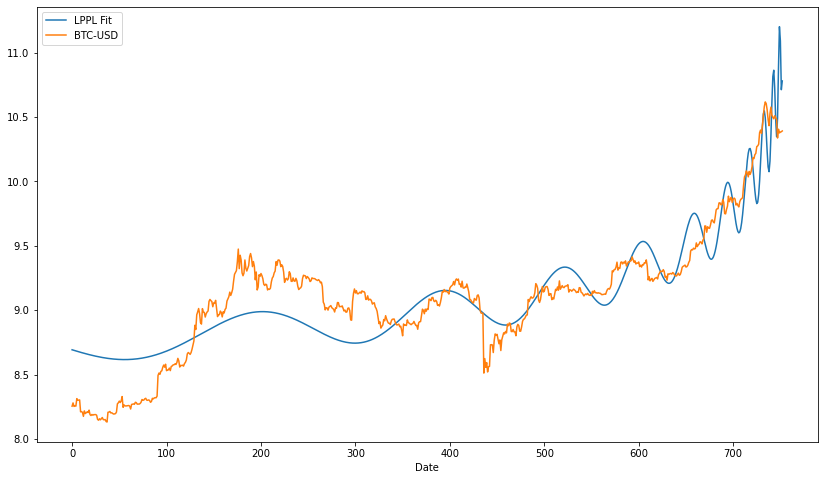

In [8]:
for i in solutions:
    tc = i["cof"][0]
    m =  i["cof"][1]
    w =  i["cof"][2]
    
    lin_vals = matrix_equation(tc, m, w)
    
    a  = lin_vals[0] 
    b  = lin_vals[1]
    c1 = lin_vals[2] 
    c2 = lin_vals[3]

    lppl_fit = [lppl(t, tc, m, w, a, b, c1, c2) for t in DataSeries[0]]
    price_data = DataSeries[1]
    
    data = pd.DataFrame({
        'Date': DataSeries[0],
        'LPPL Fit': lppl_fit,
        'BTC-USD': np.log(price_data),
    })
    data = data.set_index('Date')
    data.plot(figsize=(14,8))

In [9]:
print("# tc = {}\n# m = {}\n# w = {}\n# a = {}\n# b = {}\n# c1 = {}\n# c2 = {}\n# -------------".format(tc,m,w,a,b,c1,c2))

# tc = 761.6156627812128
# m = -0.22372512011032097
# w = 14.82270882937068
# a = 7.332944636499687
# b = 6.194861793373225
# c1 = 0.6064964611181805
# c2 = -0.18061754402224506
# -------------


In [44]:
solution_count

1